# Scripts for testing the waveforms h5 files

In [18]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set plot font and size
font = {'size':14}
plt.rc('font', **font)

# Uncomment next two lines if romSpline is not in your PYTHONPATH
#import sys
#sys.path.append('/localdata/bkhamesra3/research_localdata/UsefulScripts/LIGO/LIGO_Scripts/LIGO_Waveforms_Scripts/')

import romspline, os, glob, h5py
import shutil as sh

import sys, random
sys.stdout.flush()

In [19]:
#Change this directory's path  to where all your data is located or comment it out and provide the full paths. 
os.chdir('/numrel/NumRel/bkhamesra3/Finalized_Waveforms/')

In [20]:
# Function Definitions:

def write_data(data, filename, filepath, hdr=""):
    strfile = open(os.path.join(filepath, filename), 'w')
    np.savetxt(strfile, data, delimiter='\n', header=hdr)
    strfile.close()
    
def filesearch(wfdir, l, m):
    
    for f in sorted(glob.glob(wfdir+'/data/Strain/Strain_TimeShifted/*.asc')):
       
        filename = os.path.basename(f)
       
        ll = int(filename.split('_')[1][0])
        mm = int(filename.split('_')[1][1:])
        if l == ll and m == mm:
            strorig_file = f
            return strorig_file
        

## Checking errors from spline interpolation

* Read data (metadata, amplitude and phase) from  h5 file
* Write into text files and Create spline interpolant 
* Extract amplitude and phase using this interpolant
* Read the original data
* Compare the spline interpolant of amplitude and phase at random time points from original data
* Compute the errors
* Compute the frequencies



In [21]:

#Extract the metadata from h5
def read_metadata(h5path_new, wfdir, failed_h5path="", failed_wfpath=""):
    
    h5file = h5py.File(h5path_new)
    
    metadata = {}

    for item in h5file.attrs.keys():
        metadata[item] = h5file.attrs[item]


    #Extract the amplitude and phase from h5. If a field is missing, send it to failed directory
    amp, phase = {}, {}

    for key in h5file.keys():
      
        if key[:3] =="amp":
            amp_lm =  h5file[key]
            ampkey = amp_lm.keys()
        
            #For missing data for some mode in amplitude - reject the waveform
            if len(ampkey)==0:
                raise ValueError("Data from amplitude - %s missing"%ampkey)
                if len(failed_h5path)>0:
                    sh.move(h5file, failed_h5path)
                    sh.move(wfdir, failed_wfpath)
            
            t_val   =  amp_lm[ampkey[0]][:]
            amp_val = amp_lm[ampkey[1]][:]
            deg_val = amp_lm[ampkey[2]].value
            err_val = amp_lm[ampkey[3]][:]
            tol_val = amp_lm[ampkey[4]].value
      
            amp[key] = {"X":t_val, "Y":amp_val, "deg":deg_val, "tol":tol_val, "errors":err_val}
        
        elif key[:5] =="phase":
            ph_lm = h5file[key]
            phkey = ph_lm.keys()
        
            #For missing data for some mode in phase  - reject the waveform
            if len(phkey)==0:
                raise ValueError("Data from phase - %s missing"%phkey)
                if len(failed_h5path)>0:
                    sh.move(h5file, failed_h5path)
                    sh.move(wfdir, failed_wfpath)
            
            t_val   = ph_lm[phkey[0]][:]
            ph_val  = ph_lm[phkey[1]][:]
            deg_val = ph_lm[phkey[2]].value
            err_val = ph_lm[phkey[3]][:]
            tol_val = ph_lm[phkey[4]].value
        
            phase[key] = {"X":t_val, "Y":ph_val, "deg":deg_val, "tol":tol_val, "errors":err_val}
        
    return [metadata, amp, phase]
    
    


In [22]:
#Create text file directories to create spline object:

def SplineInterpolationError_Amplitude(amp, testdir, ll_desired, mm_desired, verbose=False, outputfile=""):
    '''Computes the error in amplitude from spline interpolation
       Params: amp - dictionary of amplitude with all modes from h5
       ll_desired, mm_desired - (l,m) values you wish to see the comparison
       verbose - results for each mode displayed as print output
    '''
    
    if not os.path.exists(testdir+'/amp_lm.txt/'):
        os.makedirs(testdir+'/amp_lm.txt/')
    
    hdr = "#Absolute Errors in Amplitude from Spline Interpolation for all the modes \n#l \t m \t Abs Error  \t Amp @ error value \n"
    if verbose:
        print(hdr)

    if len(outputfile)>0:
        outfile = open(outputfile, 'w')
        outfile.write(hdr)
        outfile.close()
    
   

    for key in sorted(amp.keys()):
    
        #Extract l,m mode values from the key
        l = int(key.split('l')[1][0])
        m = int(key.split('m')[2])

        if m==0: continue
    
        pathfile = testdir+'/amp_lm.txt'
   
        #Write the data from dictionaries into text files - conversion of h5 into txt file 
        for k in amp[key].keys():
        
            if isinstance(amp[key][k], (list, tuple, np.ndarray)):
                data = np.column_stack(amp[key][k])
                write_data(data, k+'.txt', pathfile, hdr="")
    
            else:
                data = amp[key][k]
                strfile = open(os.path.join(pathfile, ( k + '.txt')),'w')
                strfile.write(str(data))
                strfile.close()
            
   
        #Create the spline object using data from txt files
        #Comment: There should be easier way to read the spline data from h5 directly but need to figure it out
        
        s1 = romspline.readSpline(testdir+'/amp_lm.txt')
    
    
        # Locate the file with original data  
        strorig_file = filesearch(wfdir, l, m)
    
        if not os.path.exists(strorig_file): raise IOError("%s file not found"%os.path.basename(strorig_file))
        
        
        #Read the original time, amplitude and phase data 
        t_orig, amp_orig, phase_orig = np.loadtxt(strorig_file, usecols=(0,1,2), unpack=True)
        
        #Select time values from original time array - useful to compare the errors later
        #time =  np.sort([random.uniform(t_orig.min(), t_orig.max()) for ii in range(len(t_orig/100))])
        time =  np.copy(t_orig[::10])

    
        #Compute the errors from spline interpolation - Here we look at absolute errors since amplitude is quite small at
        #at later times which results in inf/nan values
        error_amp = []
        amp_values = []
    
        for tvar in time[0:]:
       
            idx = np.asscalar(np.argwhere(tvar==t_orig))
            err_amp = (amp_orig[idx] - s1(tvar))
        
            amp_values.append(amp_orig[idx])
            error_amp.append(err_amp)
        
        error_amp = np.asarray(error_amp)
        error_amp = error_amp[~np.isnan(error_amp)]
    
        #Compute the maximum error for each mode. 
        if len(error_amp)>0:
            max_error = np.amax(error_amp)
            amp_maxerr = np.asarray(amp_values)[error_amp==max_error]
        
            msg = "%d \t %d \t %g \t %g \n"%(l, m, max_error, amp_maxerr)
            if verbose:
                print(msg)
            if len(outputfile)>0:
                outfile = open(outputfile, 'a')
                outfile.write(msg)
                outfile.close()
    

        #Plot the phase for desired phase mode
        if (l==ll_desired and m==mm_desired):
            
            #Read the original phase and amplitude data 
            t_orig, amp_orig, phase_orig = np.loadtxt(strorig_file, usecols=(0,1,2), unpack=True)
    
            plt.figure(figsize=(12,10))

            plt.plot(time, s1(time),lw=2, label='Spline interpolant')
            plt.plot(t_orig, amp_orig,lw=1.5,  label='Actual Data', ls='--')
            plt.xlabel('time', fontsize=16)
            plt.ylabel('Amplitude', fontsize=16)
            plt.tick_params(labelsize=14)
            plt.legend( fontsize=16)
            plt.savefig(os.path.join(wfdir, 'figures/')+'Amp_22_InterpolationCheck.png', dpi=500)
            #plt.show()
            plt.close()

   

    sh.rmtree(testdir+'/amp_lm.txt')
    
    
     
    



In [23]:
#Create text file directories to create spline object:

def SplineInterpolationError_Phase(phase,testdir, ll_desired, mm_desired, verbose=False, outputfile=""):
    '''Computes the error in amplitude from spline interpolation
       Params: amp - dictionary of amplitude with all modes from h5
       ll_desired, mm_desired - (l,m) values you wish to see the comparison
       verbose - results for each mode displayed as print output
    '''
    if not os.path.exists(testdir+'/phase_lm.txt/'):
        os.makedirs(testdir+'/phase_lm.txt/')
    

    hdr = "#Errors in Phase from Spline Interpolation (for all the modes) \n#l \t m \t Relative Error \t Phase @ error value \n"
    if verbose:
        print(hdr)

    if len(outputfile)>0:
        outfile = open(outputfile, 'w')
        outfile.write(hdr)
        outfile.close()
        
        
    for key in phase.keys():
    
        #Extract l,m mode from key
        l = int(key.split('l')[1][0])
        m = int(key.split('m')[1])
   
        if m==0:continue
    
        pathfile = testdir+'/phase_lm.txt'
   
        #Write the data from dictionaries into text files
        for k in phase[key].keys():
       
            if isinstance(phase[key][k], (list, tuple, np.ndarray)):
                data = np.column_stack(phase[key][k])
            
                strfile = os.path.join(pathfile, ( k + '.txt'))
                np.savetxt(strfile, data, delimiter='\n')
            else:
                data = phase[key][k]
                strfile = open(os.path.join(pathfile, ( k + '.txt')),'w')
                strfile.write(str(data))
                strfile.close()
            
   
        #Read the data using romspline to create spline object
        s2 = romspline.readSpline(testdir+'/phase_lm.txt')
    
    
        #Find the original data file and read the time, amplitude and phase data
        strorig_file = filesearch(wfdir, l, m)

        if not os.path.exists(strorig_file): raise IOError("%s file not found"%os.path.basename(strorig_file))
   
        t_orig, amp_orig, phase_orig = np.loadtxt(strorig_file, usecols=(0,1,2), unpack=True)
    
    
        #Create a time array - Here I select the time values from the original data which can be used to compute 
        #the errors of interpolation
    
        time =  np.copy(t_orig[::10])
        #time =  np.sort([random.uniform(t_orig.min(), t_orig.max()) for ii in range(len(t_orig))])

    
        #Compute the errors 
        error_phase = []
        phase_values = []
    
        for tvar in time[0:]:
        
            idx = np.asscalar(np.argwhere(tvar==t_orig))
            err_phase = (phase_orig[idx] - s2(tvar))/phase_orig[idx]
    
            phase_values.append(phase_orig[idx])
            error_phase.append(err_phase)
        
        error_phase = np.asarray(error_phase)
        error_phase = error_phase[~np.isnan(error_phase)]    #Remove nan values - can occur if denominator is extremely small
    
    
        #Compute the max error for each mode
        if len(error_phase)>0:
            max_error = np.amax(error_phase)
            phase_maxerr = np.amin(np.asarray(phase_values)[error_phase==max_error])
            msg = "%d \t %d \t %g \t %g \n"%(l, m, max_error, phase_maxerr)
            if verbose:
                print(msg)
            if len(outputfile)>0:
                outfile = open(outputfile, 'a')
                outfile.write(msg)
                outfile.close()
    
        #Compute the frequency
        if l ==2 and m==2:
            freq_real = -1.*(np.gradient(phase_orig)/np.gradient(t_orig))[0]
            freq_h5 = -1.*(np.gradient(s2(time))/np.gradient(time))[0]
            
    
        #Plot the phase for desired phase mode
        if l==ll_desired and m==mm_desired:
            plt.figure(figsize=(15,10))
        
            plt.subplot(211)
            plt.plot(time, s2(time), lw=2, label='Spline interpolant')
            plt.plot(t_orig, phase_orig, lw=1.5,  label='Actual Data', ls='--')
            plt.xlabel('time', fontsize=16)
            plt.ylabel('Phase (2,2)', fontsize=16)
            plt.tick_params(labelsize=14)
            plt.legend( fontsize=16)
        
            plt.subplot(212)
            plt.plot(time, error_phase*100, label="Percent Error")
            plt.xlabel('Time', fontsize=16)
            plt.ylabel('% Error', fontsize=16)
            plt.tick_params(labelsize=14)
            plt.savefig(os.path.join(wfdir, 'figures/')+'Phase_22_InterpolationCheck.png', dpi=500)
            plt.show()
            
            plt.close()
    
    
    sh.rmtree(testdir+'/phase_lm.txt')
    return [freq_real, freq_h5]


    
    



In [24]:
#Specify the waveform name here which you wish to test

waveform = 'GT0446'  # Change this
verbose = True

#Check if waveform exists
if not glob.glob('H5Files/NonSpinning/%s.h5'%waveform):
    raise RuntimeError("File not found")


#Copy the waveform and simulation data to another directory 

testdir = '/localdata2/bkhamesra3/.testdir'    #Change this
if not(os.path.exists(testdir)):
       os.makedirs(testdir)

h5files_path = 'H5Files/NonSpinning/'          #Change this
h5path = glob.glob(os.path.join(h5files_path, '%s.h5'%waveform))[0]
sh.copy(h5path,testdir )

h5path_new = testdir+'/%s'%os.path.basename(h5path)

h5datafile = h5py.File(h5path_new, 'r')

simname = h5datafile.attrs['alternative-names']

wfdir = glob.glob('Waveform_files/Completed/*/%s'%simname)
if len(wfdir)==0:
    raise RuntimeError("Waveform directory not found. Please check the path")
elif len(wfdir)>1:
    raise RuntimeError("Multiple waveform directories with same name found. Please delete the incorrect directories.")
else:
    wfdir = wfdir[0]
    
simdir = os.path.join(testdir, simname)

if os.path.exists(os.path.join(testdir, simname)):
    sh.rmtree(os.path.join(testdir, simname))

sh.copytree(wfdir,simdir )

wfdir_new = testdir+'/%s'%simname

#Move the waveforms and strain data to failed directory if the tests fails
failed_h5path = 'trash/Failed/H5Files/'          #Comment out if you do not want this
failed_wfpath = 'trash/Failed/Waveforms/'        #Comment out if you do not want this

ll_desired  = 2
mm_desired  = 2



In [25]:
metadata, amp_h5, phase_h5 = read_metadata(h5path_new, wfdir_new, failed_h5path, failed_wfpath)



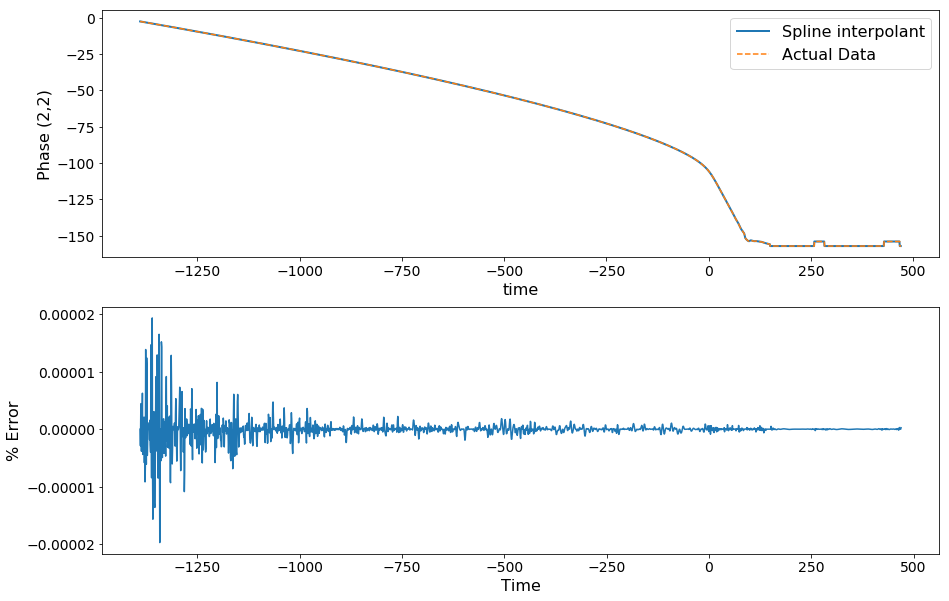

/localdata/bkhamesra3/softwares/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars


In [26]:
SplineInterpolationError_Amplitude(amp_h5, testdir, ll_desired, mm_desired, verbose=False, outputfile=wfdir+"/data/Strain/Amp_Errors.txt")
freq_real, freq_h5 = SplineInterpolationError_Phase(phase_h5, testdir, ll_desired, mm_desired, verbose=False, outputfile=wfdir+"/data/Strain/Phase_Errors.txt")



In [27]:
G = 6.67428e-11 # m^3/(kg s^2)
mass_sun = 1.98892e30 # kg
c = 2.99792458e8 # m/s
mass_sec = G * mass_sun / ( c*c*c )
simulation_mass_sec = ( 1.0 ) * mass_sec # NOTE that the 1.0 here is for 1solar mass


freq_metadata = metadata['f_lower_at_1MSUN']
freq_h5_Hz    = freq_h5/(2.*np.pi)/simulation_mass_sec
freq_real_Hz  = freq_real/(2.*np.pi)/simulation_mass_sec

print('Frequency from metadata      = %g Hz'%freq_metadata)
print('Frequency from original data = %g Hz'%freq_real_Hz)
print('Frequency from h5            = %g Hz'%freq_h5_Hz)


Frequency from metadata      = 1669.85 Hz
Frequency from original data = 1669.85 Hz
Frequency from h5            = 1667.56 Hz


In [17]:
#Remove all the copied data
sh.rmtree(testdir)
     


Corresponding outputs are saved at following locations:
1. Errors in amplitude and phase - <waveform_directory>/data/Strain/
2. Plots of Spline Interpolation of amplitude and phase ((2,2) mode only) - <waveform_directory>/figures